# Fitting a model with Markov Chain Monte Carlo

Markov Chain Monte Carlo (MCMC) is a way to infer a distribution of model parameters, given that the measurements of the output of the model are influenced by some tractable random process. In this case, performs something akin to the opposite of what a standard Monte Carlo simultion will do. Instead of starting with distributions for the parameters of a model and using them to calculate a distribution (usually related to uncertainty) in the output of the simulation, we start with a distribution of that output and look for input distributions.

 
## Ingredients

For this analysis we'll introduce the python package [PyMC](https://pymc-devs.github.io/pymc/README.html) which implements MCMC algorithms for us. Another project which performs similar calculations is [PyStan](https://pystan.readthedocs.org/en/latest/).

In [1]:
%pylab inline
import pysd
import pymc
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


For this example, we'll revisit the ebola case, only assuming that our data has some noise, and we'll use MCMC to estimate distributions for the parameters for the model. For a more detailed description of this model and the dataset see the recipe [Fitting with Optimization](http://pysd-cookbook.readthedocs.org/en/latest/analyses/fitting/Fitting_with_Optimization.html).

We'll assume that the model simulates an underlying process of disease propagation, but that the data is noisy - perhaps it represents admittance rates at a hospital, and so will be missing some cases, and may include some false positives through misdiagnosis.

In [2]:
model = pysd.read_vensim('../../models/SI Model/SI Model.mdl')

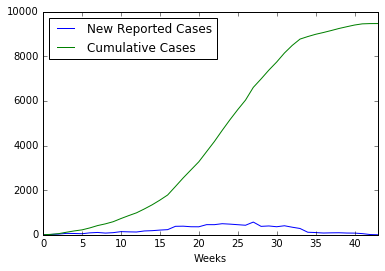

In [3]:
data = pd.read_csv('../../data/Ebola/Ebola_in_SL_Data.csv', index_col='Weeks')
data.plot();

## Recipe

#### Step 1: Establish prior distributions for the input parameters
Our first step is to establish prior distributions for the parameters for which we will be trying to infer posterior distributions. As in the optimization case, we'll modify the effective population and the contact frequency. In real epidemiological modeling, we'd have a more complex model, and we'd have some information about the population, etc. but this makes for a relatively tight example.

In [4]:
population = pymc.Uniform('total_population', lower=2, upper=50000, value=10000)
contact_frequency = pymc.Exponential('contact_frequency', beta=5, value=5)

#### Step 2: Perform the simulation
We now need to define a function that will run the model given a draw from the input distributions, and return the values that we will take as those of the fundamental underlying phenomena, before measurement noise is included.

In [5]:
@pymc.deterministic
def sim(population=population, contact_frequency=contact_frequency):
    result = model.run(params={'total_population':population,
                               'contact_frequency':contact_frequency},
                       return_columns=['infection_rate'],
                       return_timestamps=list(data.index.values))
    return result['infection_rate'].values


#### Step 3: Include noise terms
There are several ways we could include noise. If we expected no false positives, we could use a Binomial distribution, such that of `n` possible cases that could be reported, only a fraction `p` would be reported, and other cases missed. If we only want to model false positives, we could assume that there was an average rate of false positives, with the data following a poisson distribution. The full rate would be the sum of these two processes.

For now, however, we'll simplify the analysis by only looking at the Poisson noise component. The mean of the poisson process will be the results of our simulation.

This is where we include our measured data into the model. PyMC will know how to calculate the log likelihood of seeing the observed data given the assumption that the simulation result represents the underlying process, subject to Poisson noise.

In [6]:
admittances = pymc.Poisson('admittances', mu=sim,
                           value=data['New Reported Cases'], observed=True)

#### Step 4: Perform the MCMC Sampling

Now that we have set up the problem for PyMC, we need only to run the MCMC sampler. What this will do, essentially, is take a trial set of points from our prior distribution, simulate the model, and evaluate the likelihood of the data given those input parameters, the simulation model, and the noise distribution. It will then use bayes law to decide whether to keep the trial points or throw them away. It will then choose a new set of points and start over. (There is a lot more cleverness happening than this, of course. If you want to know how it works, I recommend [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/).

First we assemble the various pieces of the data flow that we built up into a model that pymc can recognize, and instantiate a sampler `MCMC` to run the algorithm for us.

Then we'll ask the MCMC algorithm to run until it has kept 20000 points. We'll throw out the first 1000 of these, as they are likely to be biased towards the initial values we set up and not representative of the overall distribution.

In [7]:
mcmdl = pymc.Model([population, contact_frequency, sim, admittances])
mcmc = pymc.MCMC(mcmdl)
mcmc.sample(20000,1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 68.7 sec

#### Step 5: Look at the distribution

We can now evaluate the results by looking at the series of points we 'kept'. These are stored as traces within the population and contact frequency objects we built earlier. 

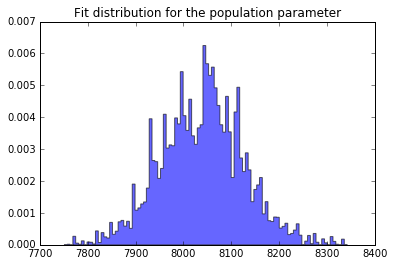

In [8]:
plt.hist(population.trace[:], bins=100, histtype='stepfilled', normed=True, alpha=.6);
plt.title('Fit distribution for the population parameter');

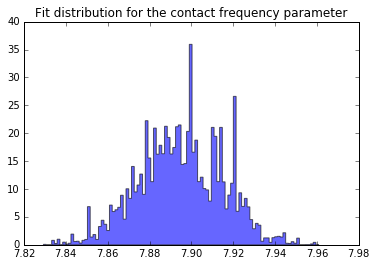

In [9]:
plt.hist(contact_frequency.trace[:], bins=100, histtype='stepfilled', normed=True, alpha=.6);
plt.title('Fit distribution for the contact frequency parameter');

#### Step 6: Understand the correlation between our parameter distributions
PyMC has calculated for us the input distributions for the parameters we have based upon our data. This isn't the whole story, however, as these values are not independent of one another. We can see by plotting them against one another that there is correlation:

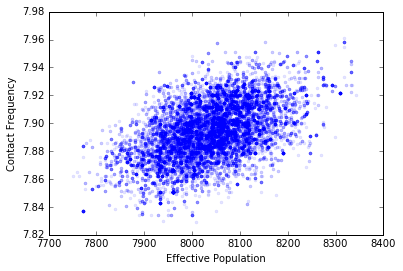

In [10]:
plt.plot(population.trace[:], contact_frequency.trace[:], '.', alpha=.1)
plt.xlabel('Effective Population')
plt.ylabel('Contact Frequency');

If we use these distributions in the future to propagate uncertainty through the model (say in doing a policy test) we should make sure that we're including this correlation. The simplest way to do this is just to use the traces themselves as inputs into a normal Monte Carlo error propagation calculation, making sure that we use the same index in each trace for any given run. This will automatically include the correlation for us. Clever!

## Resources:

The analysis in this notebook is inspired by blogt posts by Abraham Flaxman:
- http://healthyalgorithms.com/2010/11/29/mcmc-in-python-statistical-model-stuck-on-a-stochastic-system-dynamics-model-in-pymc/

- http://healthyalgorithms.com/2010/10/19/mcmc-in-python-how-to-stick-a-statistical-model-on-a-system-dynamics-model-in-pymc/ 

A great resource for learning about MCMC is [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)